# JAX_wildlife.API - Native API and Wrapper Usage
This notebook shows the native Flax module and the wrapper helpers in `JAX_wildlife_utils.py` with small, fast cells.

## Imports and configuration

In [1]:

import logging, jax, jax.numpy as jnp
from JAX_wildlife_utils import (
    SimpleCNN,
    load_dataset,
    TrainConfig,
    train,
    evaluate,
    plot_confusion_matrix,
)

logging.basicConfig(level=logging.INFO)
DATA_DIR = './data/animals10'
# You can point this to any folder-per-class dataset; default uses ./data/animals10
IMAGE_SIZE = (128, 128)
LIMIT_PER_CLASS = 20


## Native API forward pass 
Instantiate `SimpleCNN` directly and run a dummy forward pass.

In [2]:

rng = jax.random.PRNGKey(0)
model = SimpleCNN(num_classes=10)
params = model.init({"params": rng, "dropout": rng}, jnp.ones((1, *IMAGE_SIZE, 3)), train=True)["params"]
dummy_logits = model.apply({"params": params}, jnp.ones((1, *IMAGE_SIZE, 3)), train=False)
dummy_logits.shape


INFO:2025-12-16 04:59:02,441:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


(1, 10)

## Load dataset via wrapper
Uses `load_dataset` to fetch a small slice, prints class names and array shapes. Preprocessing (resize + normalize) happens inside the helper; no extra steps here.

In [3]:

Xs, ys, class_names = load_dataset(
    DATA_DIR, image_size=IMAGE_SIZE, splits=(0.7, 0.15, 0.15), limit_per_class=LIMIT_PER_CLASS
)
print('classes:', class_names)
{split: arr.shape for split, arr in Xs.items()}


classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


{'train': (140, 128, 128, 3),
 'val': (30, 128, 128, 3),
 'test': (30, 128, 128, 3)}

## Train one epoch with the wrapper
Build `TrainConfig` and run `train` for a short pass.

In [4]:

config = TrainConfig(image_size=IMAGE_SIZE, num_classes=len(class_names), num_epochs=1, batch_size=32, learning_rate=1e-3)
state, history = train(Xs['train'], ys['train'], Xs['val'], ys['val'], config)
history


INFO:JAX_wildlife_utils:Epoch 1/1 loss=3.1664 acc=0.0771 val_acc=0.0333


{'loss': [np.float64(3.166378974914551)],
 'acc': [np.float64(0.07708333432674408)],
 'val_acc': [0.03333333333333333]}

## Evaluate and visualize
Compute metrics with `evaluate` and render a confusion matrix using `plot_confusion_matrix`.

{'accuracy': 0.1, 'precision': 0.011111111111111112, 'recall': 0.1111111111111111, 'confusion_matrix': array([[0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0]]), 'y_pred': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8], dtype=int32)}


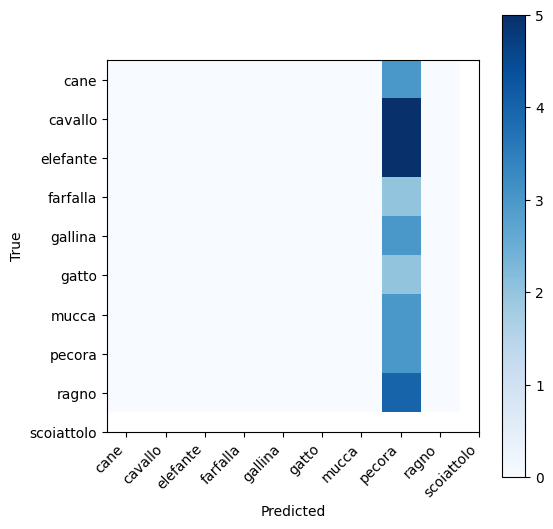

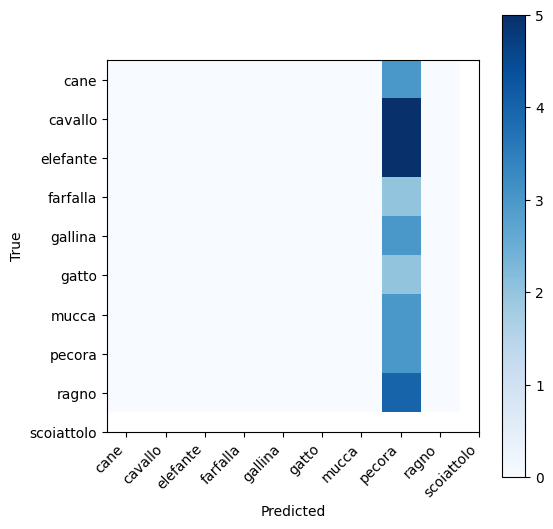

In [5]:

metrics = evaluate(state, Xs['test'], ys['test'], class_names)
print(metrics)
fig = plot_confusion_matrix(metrics['confusion_matrix'], class_names)
fig
